In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_auc_score, roc_curve)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [31]:
#Estas 4 funciones son para el analisis del EDA

def plot_distribution(data, columns, target_col='Diagnosis', figsize=(8, 4)):
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Histograma por clase
            for target_val in data[target_col].unique():
                subset = data[data[target_col] == target_val]
                axes[i].hist(subset[col], alpha=0.7, label=f'Clase {target_val}', bins=20)
            
            axes[i].set_title(f'Distribución de {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frecuencia')
            axes[i].legend()
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(data, figsize=(8, 4)):
    
    corr_matrix = data.corr()
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Generar heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdYlBu_r',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Matriz de Correlación de Variables', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

def plot_outliers(data, columns, target_col='Diagnosis', figsize=(8, 4)):
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            sns.boxplot(data=data, x=target_col, y=col, ax=axes[i])
            axes[i].set_title(f'Boxplot de {col}')
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_class_balance(y, title="Distribución de Clases"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # Gráfico de barras
    value_counts = y.value_counts()
    ax1.bar(value_counts.index, value_counts.values, color='skyblue')
    ax1.set_title(f'{title} - Conteo')
    ax1.set_xlabel('Clase')
    ax1.set_ylabel('Cantidad')
    
    for i, v in enumerate(value_counts.values):
        ax1.text(i, v + 5, str(v), ha='center', va='bottom')
    
    # Gráfico de pastel
    ax2.pie(value_counts.values, labels=[f'Clase {i}' for i in value_counts.index], 
            autopct='%1.1f%%', colors=sns.color_palette("pastel"))
    ax2.set_title(f'{title} - Porcentaje')
    
    plt.tight_layout()
    plt.show()

# Estas 3 ultimas funciones son para el analisis del Resultado, Evaluación

def evaluate_model(model, X_test, y_test, y_pred, model_name):
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    
    return results

def plot_confusion_matrices(models_results, y_test, figsize=(15, 12)):

    n_models = len(models_results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, (model_name, results) in enumerate(models_results.items()):
        if i < len(axes):
            y_pred = results['predictions']
            cm = confusion_matrix(y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'Matriz de Confusión - {model_name}')
            axes[i].set_xlabel('Predicción')
            axes[i].set_ylabel('Real')
    
    # Ocultar ejes vacíos
    for i in range(len(models_results), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(models_results, y_test, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    for model_name, results in models_results.items():
        y_pred_proba = results.get('probabilities')
        if y_pred_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC - Comparación de Modelos')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [32]:
# Cargar CSV
data = pd.read_csv('breast_cancer_wisconsin.csv')
data.head()

,ID,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [33]:
#Eliminación de columna irrelevante para el modelo
data = data.drop(columns=['ID'])

## Fase 1: Análisis exploratorio de datos (EDA)

In [34]:
# CARGA Y EXPLORACIÓN INICIAL DE DATOS

print(f"\n📊 INFORMACIÓN GENERAL DEL DATASET:")
print(f"   • Forma del dataset: {data.shape}")
print(f"   • Número de variables: {data.shape[1] - 1}")
print(f"   • Número de observaciones: {data.shape[0]}")

print(f"\n📋 PRIMERAS 10 FILAS:")
print(data.head(10))

print(f"\n🔍 TIPOS DE DATOS:")
print(data.dtypes.value_counts())

print(f"\n📈 INFORMACIÓN DETALLADA:")
data.info()

print(f"\n❌ DATOS FALTANTES:")
missing_data = data.isnull().sum()
print(f"   • Total de valores faltantes: {missing_data.sum()}")
if missing_data.sum() > 0:
    print(missing_data[missing_data > 0])
else:
    print("   • No hay valores faltantes en el dataset ✅")

print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
print(data.describe())


📊 INFORMACIÓN GENERAL DEL DATASET:
   • Forma del dataset: (569, 31)
   • Número de variables: 30
   • Número de observaciones: 569

📋 PRIMERAS 10 FILAS:
  Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M        17.99         10.38          122.80     1001.0   
1         M        20.57         17.77          132.90     1326.0   
2         M        19.69         21.25          130.00     1203.0   
3         M        11.42         20.38           77.58      386.1   
4         M        20.29         14.34          135.10     1297.0   
5         M        12.45         15.70           82.57      477.1   
6         M        18.25         19.98          119.60     1040.0   
7         M        13.71         20.83           90.20      577.9   
8         M        13.00         21.82           87.50      519.8   
9         M        12.46         24.04           83.97      475.9   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0       


🎯 ANÁLISIS DE LA VARIABLE OBJETIVO:
   • Clase M (Maligno): 357 (62.7%)
   • Clase B (Benigno): 212 (37.3%)


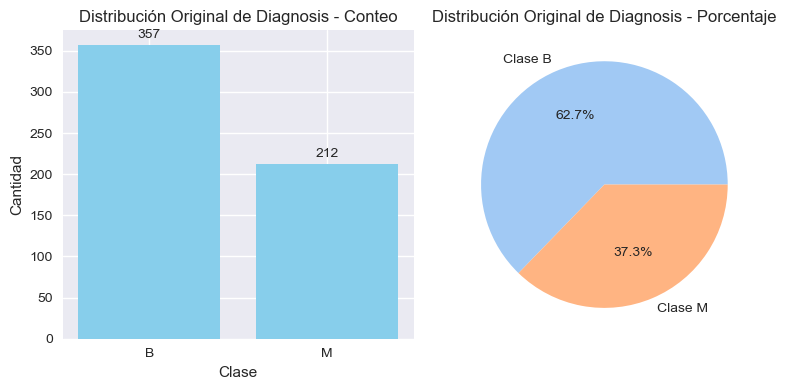

In [35]:
# ANÁLISIS DE LA VARIABLE OBJETIVO
print(f"\n🎯 ANÁLISIS DE LA VARIABLE OBJETIVO:")
target_distribution = data['Diagnosis'].value_counts()
print(f"   • Clase M (Maligno): {target_distribution[0]} ({target_distribution[0]/len(data)*100:.1f}%)")
print(f"   • Clase B (Benigno): {target_distribution[1]} ({target_distribution[1]/len(data)*100:.1f}%)")

plot_class_balance(data['Diagnosis'], "Distribución Original de Diagnosis")

In [36]:
data.columns

Index(['Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [37]:
main_features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

In [38]:
#  DETECCIÓN DE OUTLIERS
# ========================

print(f"\n⚠️  ANÁLISIS DE OUTLIERS:")

# Detectar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_count = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count[col] = len(outliers)
    return outliers_count

outliers_info = detect_outliers_iqr(data, main_features)
print(f"\n📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):")
for feature, count in outliers_info.items():
    print(f"   • {feature:<25}: {count:3d} outliers")


⚠️  ANÁLISIS DE OUTLIERS:

📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):
   • radius_mean              :  14 outliers
   • texture_mean             :   7 outliers
   • perimeter_mean           :  13 outliers
   • area_mean                :  25 outliers
   • smoothness_mean          :   6 outliers
   • compactness_mean         :  16 outliers
   • concavity_mean           :  18 outliers
   • concave_points_mean      :  10 outliers
   • symmetry_mean            :  15 outliers
   • fractal_dimension_mean   :  15 outliers
   • radius_se                :  38 outliers
   • texture_se               :  20 outliers
   • perimeter_se             :  38 outliers
   • area_se                  :  65 outliers
   • smoothness_se            :  30 outliers
   • compactness_se           :  28 outliers
   • concavity_se             :  22 outliers
   • concave_points_se        :  19 outliers
   • symmetry_se              :  27 outliers
   • fractal_dimension_se     :  28 outliers
   • radius_worst       

In [39]:
data.shape

(569, 31)

In [40]:
#Conversión [Diagnosis] variables categoricas a numericas
# Crear instancia del codificador
le = LabelEncoder()
# Ajustar y transformar Diagnosis
data['Diagnosis'] = le.fit_transform(data['Diagnosis'])
# Verificar resultado
print(data['Diagnosis'].value_counts())

Diagnosis
0    357
1    212
Name: count, dtype: int64


In [41]:
data.head(5)

,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


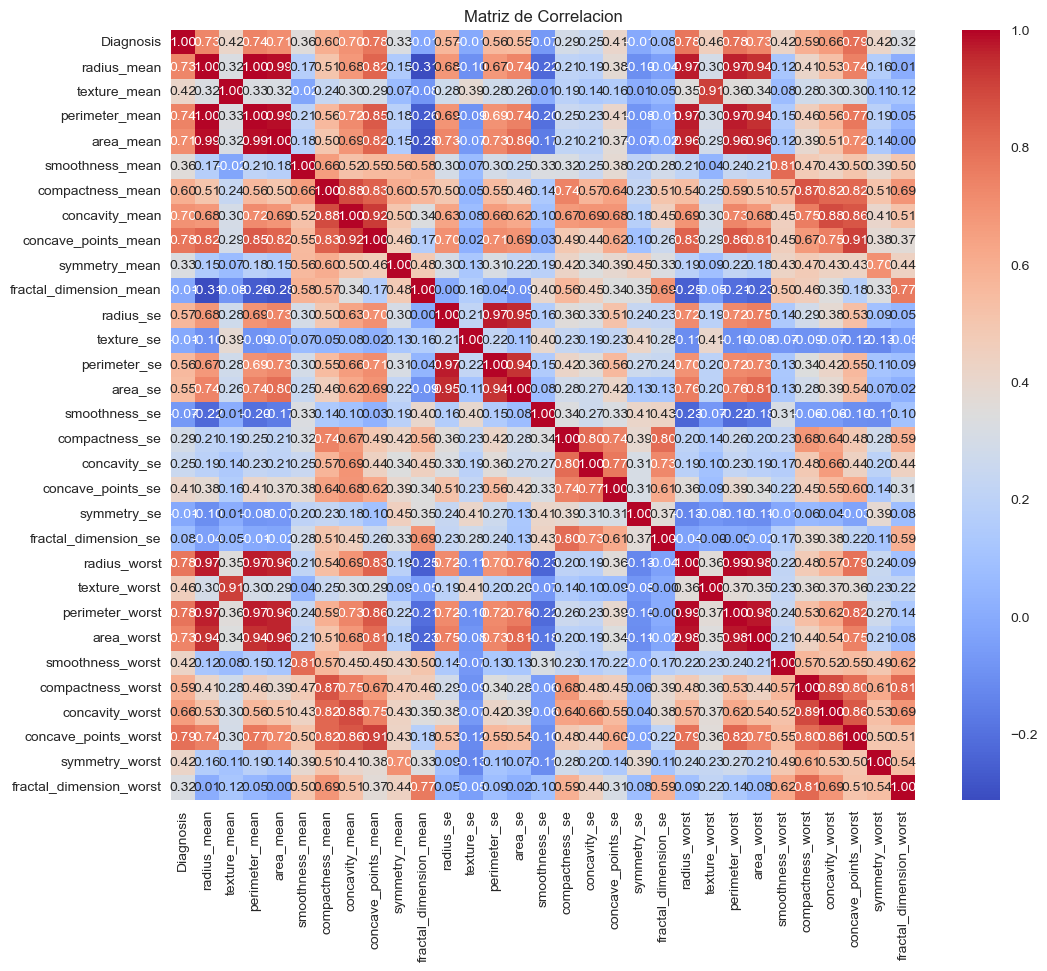

In [42]:
#Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlacion')
plt.show()

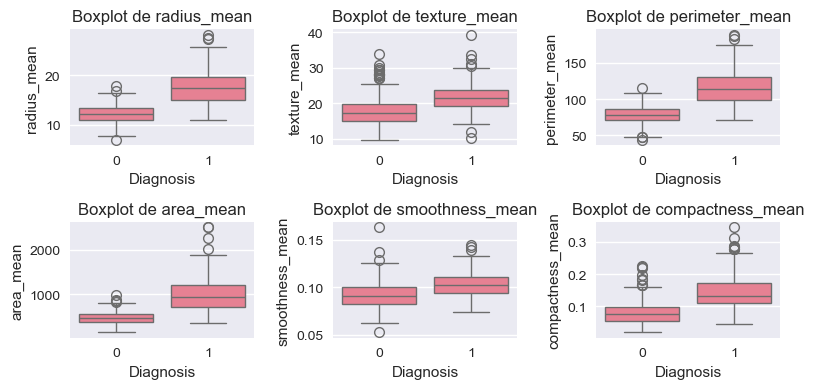

In [43]:
# Boxplots de las variables respect a la variable objetivo Diagnosis
plot_outliers(data, main_features[:6],  target_col='Diagnosis')

## Fase 2: Preprocesamiento y tratamiento de datos

In [44]:
# PREPARACIÓN DE DATOS
# =======================

print(f"\n🔧 PREPARACIÓN DE DATOS:")

# Separar características y variable objetivo
X = data.drop('Diagnosis', axis=1)
y = data['Diagnosis']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

print(f"   • Tamaño conjunto entrenamiento: {X_train.shape}")
print(f"   • Tamaño conjunto prueba: {X_test.shape}")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   • Características escaladas ✅")


🔧 PREPARACIÓN DE DATOS:
   • Tamaño conjunto entrenamiento: (426, 30)
   • Tamaño conjunto prueba: (143, 30)
   • Características escaladas ✅



⚖️  BALANCEADO DE DATOS:
   • Ratio de balance: 0.596
   • Aplicando SMOTE + Tomek Links...
   • Datos balanceados:
     - Antes: {0: 267, 1: 159}
     - Después: {0: 265, 1: 265}


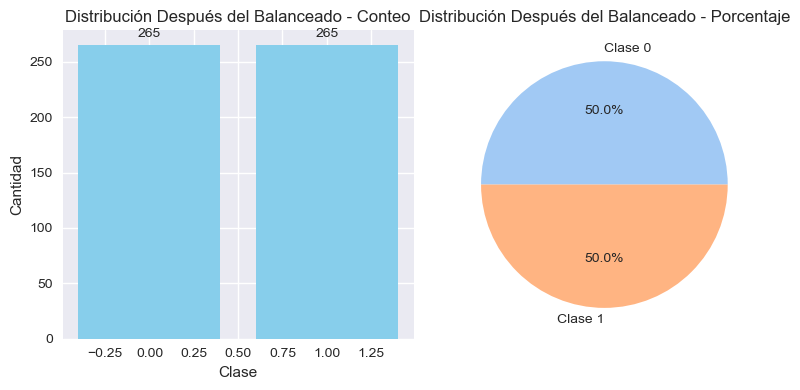

In [46]:
# BALANCEADO DE DATOS (OPCIONAL)
# =================================

print(f"\n⚖️  BALANCEADO DE DATOS:")

# Verificar si es necesario balancear
class_counts = y_train.value_counts()
balance_ratio = min(class_counts) / max(class_counts)
print(f"   • Ratio de balance: {balance_ratio:.3f}")

if balance_ratio < 0.8:  # Si el desbalance es significativo
    print(f"   • Aplicando SMOTE + Tomek Links...")
    
    # Aplicar SMOTE + Tomek Links Si quiero solo SMOTE pongo SMOTE
    smote_tomek = SMOTETomek(random_state=42)
    X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_scaled, y_train)
    
    print(f"   • Datos balanceados:")
    print(f"     - Antes: {y_train.value_counts().to_dict()}")
    print(f"     - Después: {pd.Series(y_train_balanced).value_counts().to_dict()}")
    
    # Visualizar el balanceado
    plot_class_balance(pd.Series(y_train_balanced), "Distribución Después del Balanceado")
    
    # Usar datos balanceados
    X_train_final = X_train_balanced
    y_train_final = y_train_balanced
else:
    print(f"   • No es necesario balancear los datos")
    X_train_final = X_train_scaled
    y_train_final = y_train

## Fase 3: Modelado

In [47]:
# Implementación de modelos base
## Support Vector Machine (SVM) 
## Decision Tree 
## Random Forest 
## XGBoost
## Ensemble Voting

In [48]:
# ENTRENAMIENTO DE MODELOS
# ============================

print(f"\n🤖 ENTRENAMIENTO DE MODELOS:")
print("=" * 40)

models_results = {}

# 2. Support Vector Machine
print("🔹 Entrenando SVM...")
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_final, y_train_final)
svm_pred = svm_model.predict(X_test_scaled)
models_results['SVM'] = {
    'model': svm_model,
    'predictions': svm_pred
}

# 3. Decision Tree
print("🔹 Entrenando Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_final, y_train_final)
dt_pred = dt_model.predict(X_test_scaled)
models_results['Decision Tree'] = {
    'model': dt_model,
    'predictions': dt_pred
}

# 4. Random Forest
print("🔹 Entrenando Random Forest...")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train_final)
rf_pred = rf_model.predict(X_test_scaled)
models_results['Random Forest'] = {
    'model': rf_model,
    'predictions': rf_pred
}

# 5. XGBoost
print("🔹 Entrenando XGBoost...")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_final, y_train_final)
xgb_pred = xgb_model.predict(X_test_scaled)
models_results['XGBoost'] = {
    'model': xgb_model,
    'predictions': xgb_pred
}


# 6. Ensemble
print("🔹 Entrenando  Ensemble...")
ensemble_model = VotingClassifier(
    estimators = [('svm', svm_model), ('dtc', dt_model), ('rfc', rf_model)],
    voting = 'soft'
)
ensemble_model.fit(X_train_final, y_train_final)
ensemble_pred = ensemble_model.predict(X_test_scaled)
models_results['Ensemble'] = {
    'model': ensemble_model,
    'predictions': ensemble_pred
}


🤖 ENTRENAMIENTO DE MODELOS:
🔹 Entrenando SVM...
🔹 Entrenando Decision Tree...
🔹 Entrenando Random Forest...
🔹 Entrenando XGBoost...
🔹 Entrenando  Ensemble...


In [49]:
# EVALUACIÓN DE MODELOS
# =========================

print(f"\n📊 EVALUACIÓN DE MODELOS:")
print("=" * 50)

# Calcular métricas para todos los modelos
evaluation_results = []

for model_name, results in models_results.items():
    metrics = evaluate_model(
        results['model'], 
        X_test_scaled, 
        y_test, 
        results['predictions'], 
        model_name
    )
    evaluation_results.append(metrics)
    
# Crear DataFrame con resultados
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.set_index('Model')
results_df = results_df.round(4)

print(f"\n📋 TABLA COMPARATIVA DE RESULTADOS:")
print("=" * 60)
print(results_df)

# Identificar el mejor modelo por métrica
print(f"\n🏆 MEJORES MODELOS POR MÉTRICA:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    best_model = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    print(f"   • {metric:<10}: {best_model} ({best_score:.4f})")


📊 EVALUACIÓN DE MODELOS:

📋 TABLA COMPARATIVA DE RESULTADOS:
               Accuracy  Precision  Recall  F1-Score
Model                                               
SVM              0.9790     1.0000  0.9434    0.9709
Decision Tree    0.9231     0.9565  0.8302    0.8889
Random Forest    0.9650     0.9800  0.9245    0.9515
XGBoost          0.9650     1.0000  0.9057    0.9505
Ensemble         0.9650     1.0000  0.9057    0.9505

🏆 MEJORES MODELOS POR MÉTRICA:
   • Accuracy  : SVM (0.9790)
   • Precision : SVM (1.0000)
   • Recall    : SVM (0.9434)
   • F1-Score  : SVM (0.9709)


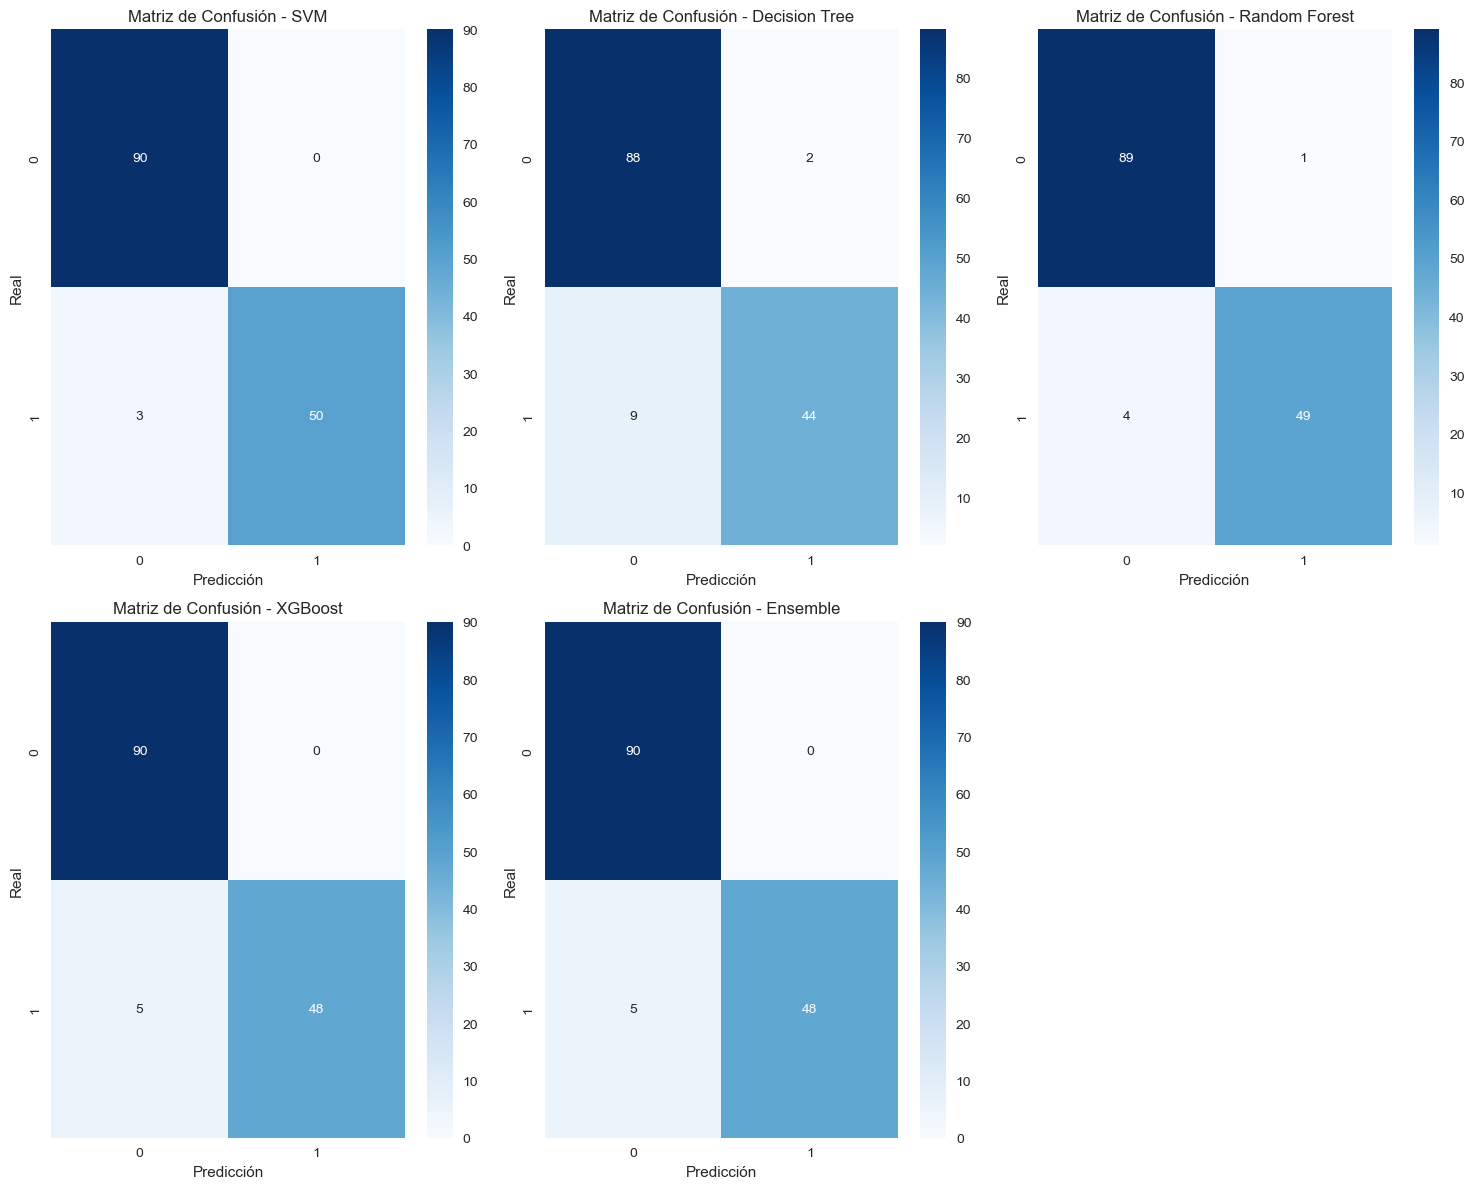

In [50]:
plot_confusion_matrices(models_results, y_test)

## Fase 4: Optimización de hiperparámetros

In [51]:
# Optimización de hiperparámetros
params = {
    "SVM": {
        "kernel": ["rbf"],
        "C": [0.1, 1, 10],
    },
    "DT": {
        "max_depth": [5, 10, 20]
    },
    "RF": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10],
    },
    "XGB": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10],
    }
}

In [52]:
modelos = {
    'SVM': SVC(probability=True, random_state=42),
    'DT': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [55]:
for model_name, model in modelos.items():
    print(f"Búsqueda de parámetros para {model_name}:")
    print(f"Los posibles parámetros son: {params[model_name]}")
    grid_search = GridSearchCV(model, params[model_name], cv=5, n_jobs=-1)
    grid_search.fit(X_train_final, y_train_final)

    print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
    print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_}")
    print(40*"=")

Búsqueda de parámetros para SVM:
Los posibles parámetros son: {'kernel': ['rbf'], 'C': [0.1, 1, 10]}
Mejores parámetros encontrados: {'C': 10, 'kernel': 'rbf'}
Mejor puntuación de validación cruzada: 0.9867924528301886
Búsqueda de parámetros para DT:
Los posibles parámetros son: {'max_depth': [5, 10, 20]}
Mejores parámetros encontrados: {'max_depth': 5}
Mejor puntuación de validación cruzada: 0.939622641509434
Búsqueda de parámetros para RF:
Los posibles parámetros son: {'n_estimators': [50, 100, 200], 'max_depth': [5, 10]}
Mejores parámetros encontrados: {'max_depth': 10, 'n_estimators': 200}
Mejor puntuación de validación cruzada: 0.9716981132075473
Búsqueda de parámetros para XGB:
Los posibles parámetros son: {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10]}
Mejores parámetros encontrados: {'max_depth': 10, 'n_estimators': 100}
Mejor puntuación de validación cruzada: 0.9773584905660379


In [56]:
# ENTRENAMIENTO DE MODELOS 2 OPTIMIZADOS
# ============================

print(f"\n🤖 ENTRENAMIENTO DE MODELOS OPTIMIZADOS:")
print("=" * 40)

models_results2 = {}

# 2. Support Vector Machine
print("🔹 Entrenando SVM...")
best_svm_model = SVC(C=10, kernel='rbf', probability=True, random_state=42)
best_svm_model.fit(X_train_final, y_train_final)
svm_pred = best_svm_model.predict(X_test_scaled)
models_results2['Best_SVM'] = {
    'model': best_svm_model,
    'predictions': svm_pred
}

# 3. Decision Tree
print("🔹 Entrenando Decision Tree...")
best_dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
best_dt_model.fit(X_train_final, y_train_final)
best_dt_pred = dt_model.predict(X_test_scaled)
models_results2['Best_Decision Tree'] = {
    'model': best_dt_model,
    'predictions': dt_pred
}

# 4. Random Forest
print("🔹 Entrenando Random Forest...")
best_rf_model = RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)
best_rf_model.fit(X_train_final, y_train_final)
best_rf_pred = rf_model.predict(X_test_scaled)
models_results2['Best_Random Forest'] = {
    'model': best_rf_model,
    'predictions': rf_pred
}

# 5. XGBoost
print("🔹 Entrenando XGBoost...")
best_xgb_model = XGBClassifier(max_depth=3, n_estimators=50, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb_model.fit(X_train_final, y_train_final)
xgb_pred = best_xgb_model.predict(X_test_scaled)
models_results2['Best_XGBoost'] = {
    'model': best_xgb_model,
    'predictions': xgb_pred
}


# 6. Ensemble
print("🔹 Entrenando  Ensemble...")
best_ensemble_model = VotingClassifier(
    estimators = [('svm', best_svm_model), ('dtc', best_dt_model), ('rfc', best_rf_model)],
    voting = 'soft'
)
best_ensemble_model.fit(X_train_final, y_train_final)
ensemble_pred = best_ensemble_model.predict(X_test_scaled)
models_results2['Best_Ensemble'] = {
    'model': best_ensemble_model,
    'predictions': ensemble_pred
}


🤖 ENTRENAMIENTO DE MODELOS OPTIMIZADOS:
🔹 Entrenando SVM...
🔹 Entrenando Decision Tree...
🔹 Entrenando Random Forest...
🔹 Entrenando XGBoost...
🔹 Entrenando  Ensemble...


In [57]:
# EVALUACIÓN DE MODELOS OPTIMIZADOS
# =========================

print(f"\n📊 EVALUACIÓN DE MODELOS OPTIMIZADOS:")
print("=" * 50)

# Calcular métricas para todos los modelos
evaluation_results2 = []

for model_name, results in models_results2.items():
    metrics = evaluate_model(
        results['model'], 
        X_test_scaled, 
        y_test, 
        results['predictions'], 
        model_name
    )
    evaluation_results2.append(metrics)
    
# Crear DataFrame con resultados
results_df = pd.DataFrame(evaluation_results2)
results_df = results_df.set_index('Model')
results_df = results_df.round(4)

print(f"\n📋 TABLA COMPARATIVA DE RESULTADOS:")
print("=" * 60)
print(results_df)

# Identificar el mejor modelo por métrica
print(f"\n🏆 MEJORES MODELOS POR MÉTRICA:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    best_model = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    print(f"   • {metric:<10}: {best_model} ({best_score:.4f})")


📊 EVALUACIÓN DE MODELOS OPTIMIZADOS:

📋 TABLA COMPARATIVA DE RESULTADOS:
                    Accuracy  Precision  Recall  F1-Score
Model                                                    
Best_SVM              0.9720     1.0000  0.9245    0.9608
Best_Decision Tree    0.9231     0.9565  0.8302    0.8889
Best_Random Forest    0.9650     0.9800  0.9245    0.9515
Best_XGBoost          0.9650     1.0000  0.9057    0.9505
Best_Ensemble         0.9650     1.0000  0.9057    0.9505

🏆 MEJORES MODELOS POR MÉTRICA:
   • Accuracy  : Best_SVM (0.9720)
   • Precision : Best_SVM (1.0000)
   • Recall    : Best_SVM (0.9245)
   • F1-Score  : Best_SVM (0.9608)


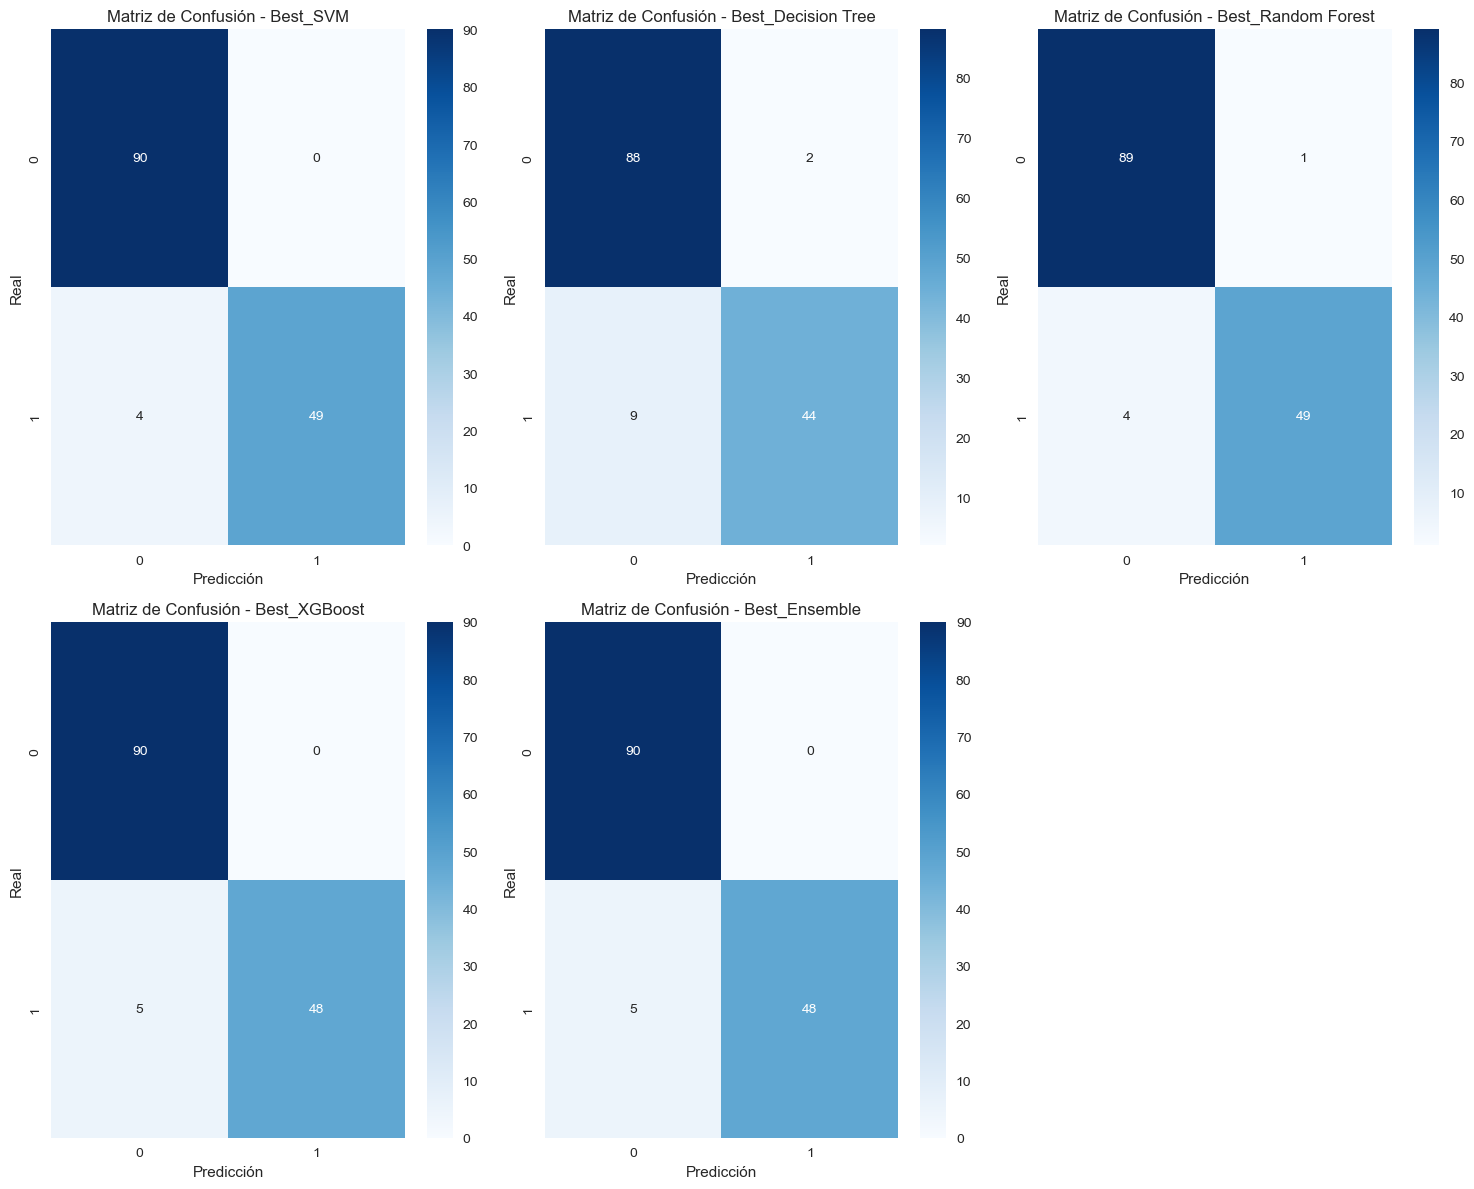

In [59]:
# Matriz de confusión
plot_confusion_matrices(models_results2, y_test)

## Fase 4: Validación cruzada (10-fold)

In [60]:
## Implemente 10-fold cross-validation para todos los modelos optimizados

from sklearn.model_selection import cross_validate
# Metricas
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Diccionario
cv_results = {}

# Evaluar cada modelo
for model_name, results in models_results2.items():
    scores = cross_validate(results['model'], X_train_final, y_train_final, cv=10, scoring=scoring)

    cv_results[model_name] = {
        'Accuracy (mean)': scores['test_accuracy'].mean(),
        'Precision (mean)': scores['test_precision'].mean(),
        'Recall (mean)': scores['test_recall'].mean(),
        'F1-Score (mean)': scores['test_f1'].mean()
    }

# Crear DataFrame con los resultados
cv_df = pd.DataFrame(cv_results).T  

# Mostrar tabla ordenada
print("\n✅ VALIDACIÓN CRUZADA (10-fold) :")
display(cv_df.round(4))  # Redondear para mejor visualización


✅ VALIDACIÓN CRUZADA (10-fold) :


,Accuracy (mean),Precision (mean),Recall (mean),F1-Score (mean)
Best_SVM,0.9868,0.9892,0.9849,0.9869
Best_Decision Tree,0.9434,0.9511,0.9393,0.9430
Best_Random Forest,0.9679,0.9639,0.9736,0.9683
Best_XGBoost,0.9774,0.9752,0.9811,0.9775
Best_Ensemble,0.9679,0.9648,0.9735,0.9686



📈 GENERANDO VISUALIZACIONES:


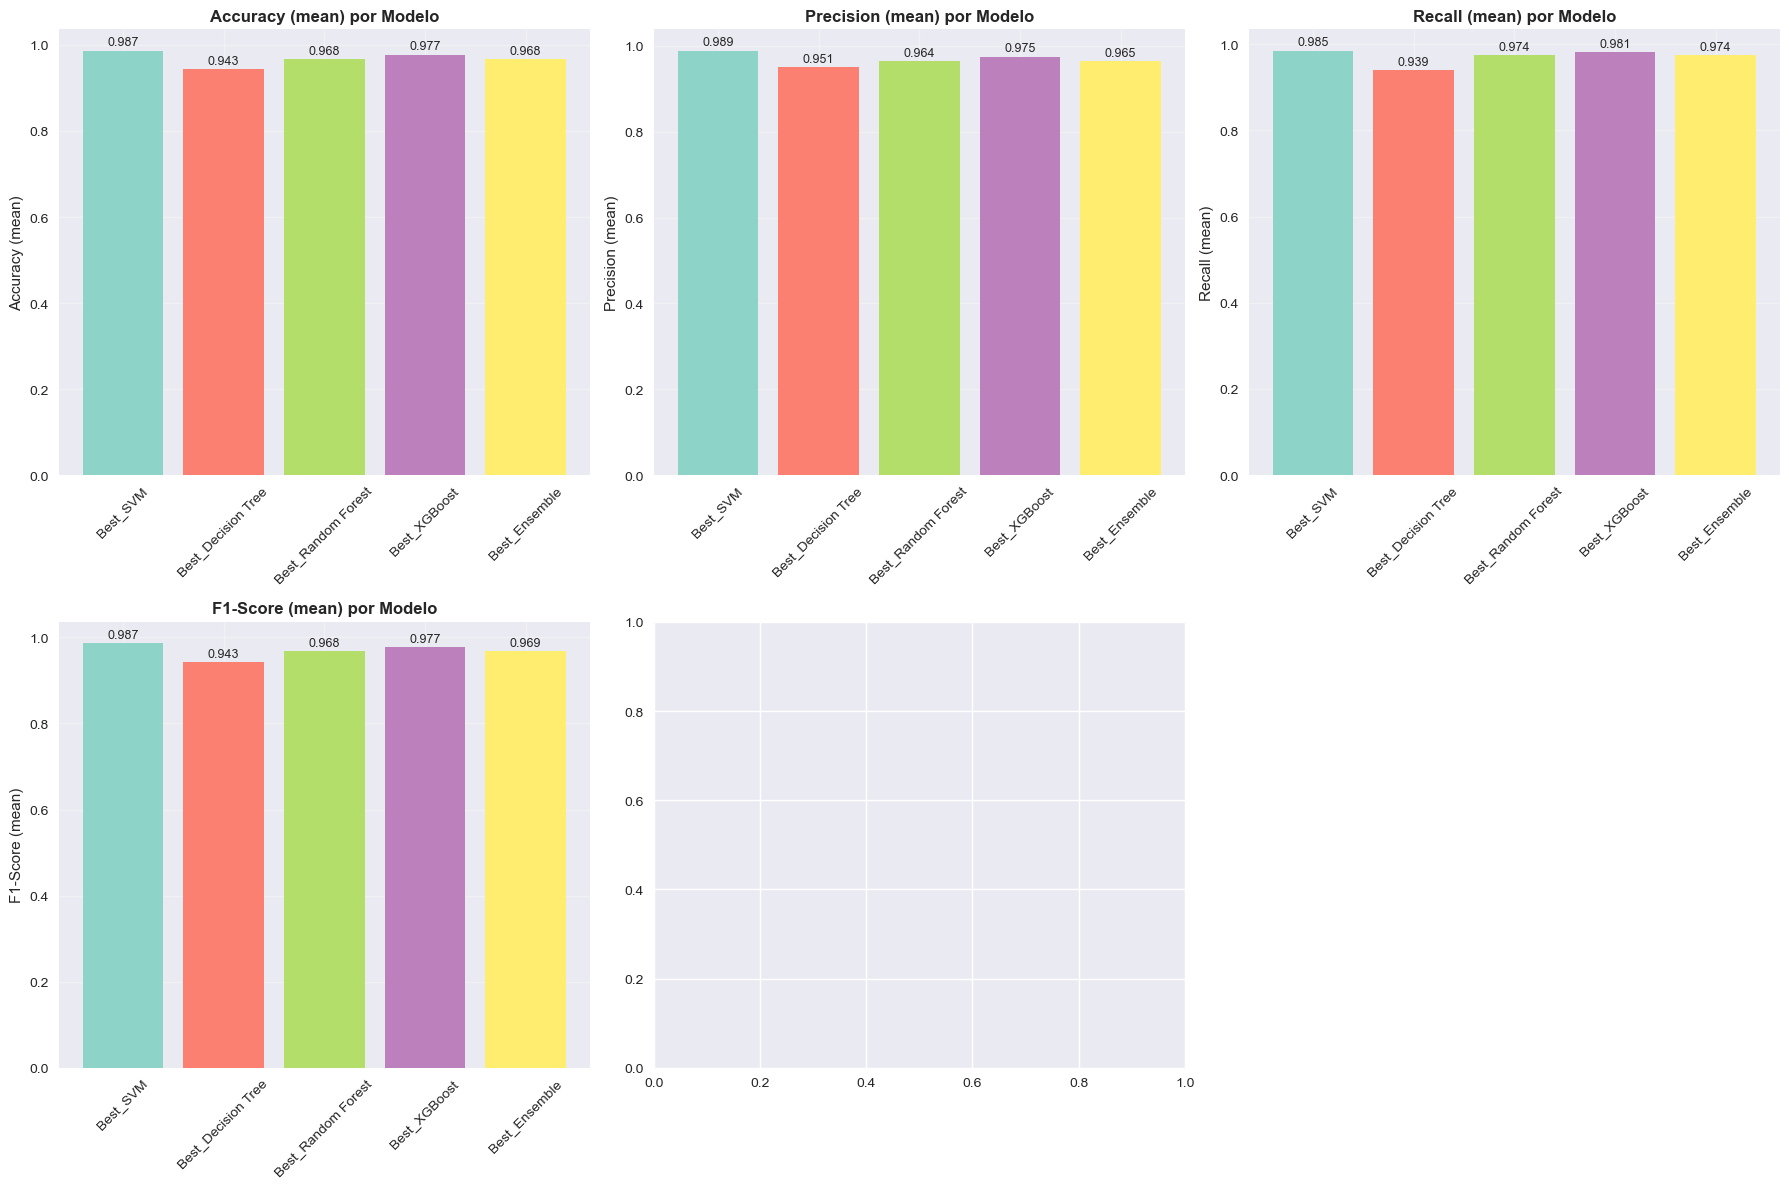

In [61]:
# VISUALIZACIÓN DE RESULTADOS
# ===============================

print(f"\n📈 GENERANDO VISUALIZACIONES:")

# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics = ['Accuracy (mean)', 'Precision (mean)', 'Recall (mean)', 'F1-Score (mean)']
colors = plt.cm.Set3(np.linspace(0, 1, len(cv_df)))

for i, metric in enumerate(metrics):
    if i < len(axes):
        bars = axes[i].bar(cv_df.index, cv_df[metric], color=colors)
        axes[i].set_title(f'{metric} por Modelo', fontweight='bold')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)
        
        # Agregar valores en las barras
        for bar, value in zip(bars, cv_df[metric]):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# Ocultar el último subplot si es necesario
if len(metrics) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()